In [1]:
import pandas as pd
import numpy as np
from tratamento import mudar_tipo_dados, remover_variavel
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from scipy.stats import kstest, norm, mannwhitneyu, ks_2samp
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier






In [2]:
df = pd.read_csv("datasets/Abandono_clientes.csv", sep=',')


In [3]:
remover_variavel(df, 'RowNumber')
remover_variavel(df, 'CustomerId')
remover_variavel(df, 'Surname')
remover_variavel(df, 'Gender') #Gender será removido para não enviezar ou deixar o modelo discriminante


continuous_vars = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

categorical_vars = [ 'Geography']

binary_vars = ['HasCrCard', 'IsActiveMember']

In [4]:
X = df.drop('Exited',axis=1)
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
preprocessor = ColumnTransformer(
    transformers=[
        ('target_encoder', OneHotEncoder(), categorical_vars),
        ('scaler', StandardScaler(), continuous_vars),
        ('binary', 'passthrough', binary_vars)  # As variáveis binárias são passadas sem transformação
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(class_weight='balanced', random_state=42))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('target_encoder',
                                                  OneHotEncoder(),
                                                  ['Geography']),
                                                 ('scaler', StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('binary', 'passthrough',
                                                  ['HasCrCard',
                                                   'IsActiveMember'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [6]:
y_pred = pipeline.predict(X_test)
y_probas = pipeline.predict_proba(X_test)

In [7]:
df_ks = pd.DataFrame()
df_ks['real'] = y_test
df_ks['proba'] = y_probas[:, 1] # probabilidade de ser Churn

# Recover each class
class0 = df_ks[df_ks['real'] == 0]
class1 = df_ks[df_ks['real'] == 1]

ks = ks_2samp(class0['proba'], class1['proba'])
print(f'KS: {ks.statistic:.4f}')

KS: 0.5606


In [8]:
display(df_ks[df_ks['real'] == 1])

,real,proba
5202,1,0.17
2750,1,0.82
7487,1,0.92
5272,1,0.62
4640,1,0.09
...,...,...
964,1,0.49
6412,1,0.72
7853,1,0.76
1095,1,0.16


In [9]:
feature_importance = pipeline.named_steps['model'].feature_importances_

In [10]:
# Obtém os nomes das características
feature_names = X_train.columns  # Substitua por seus nomes reais de características

# Cria um dicionário associando o nome da característica à sua importância
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Ordena o dicionário por importância
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Exibe a importância das características ordenadas
for i, (feature, importance) in enumerate(sorted_feature_importance):
    print(f'Rank {i+1}: {feature} - Importance: {importance}')

Rank 1: Balance - Importance: 0.2543214078471682
Rank 2: HasCrCard - Importance: 0.14845360241857275
Rank 3: EstimatedSalary - Importance: 0.14269524780343046
Rank 4: Tenure - Importance: 0.13750778637419597
Rank 5: IsActiveMember - Importance: 0.13703193756532547
Rank 6: NumOfProducts - Importance: 0.08182262255266487
Rank 7: Geography - Importance: 0.02236021942383357
Rank 8: CreditScore - Importance: 0.01149046006245063
Rank 9: Age - Importance: 0.009033063713645519


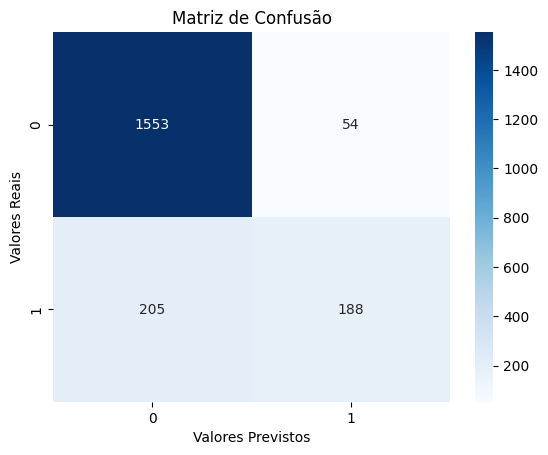

In [11]:
cm = confusion_matrix(y_test, y_pred)

# Plot da matriz de confusão usando Seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Configurações do plot
plt.title('Matriz de Confusão')
plt.xlabel('Valores Previstos')
plt.ylabel('Valores Reais')
plt.show()

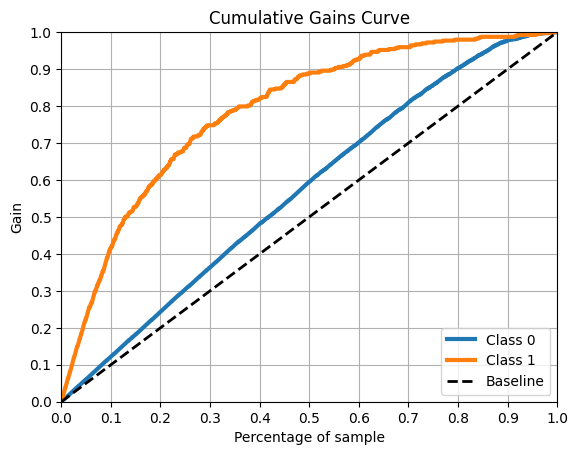

In [12]:
skplt.metrics.plot_cumulative_gain(y_test, y_probas)
plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.show()

<Axes: title={'center': 'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

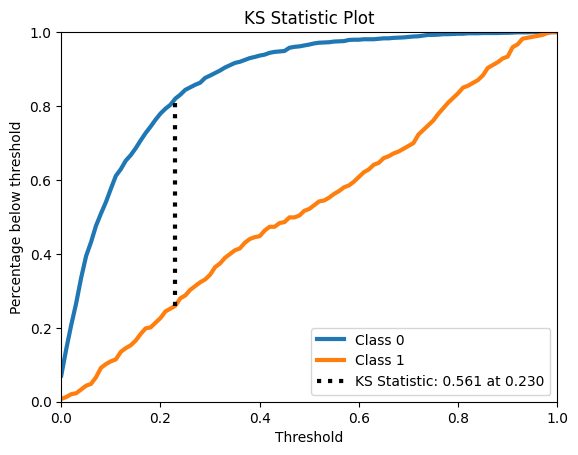

In [13]:
skplt.metrics.plot_ks_statistic(y_test, y_probas)

<Axes: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

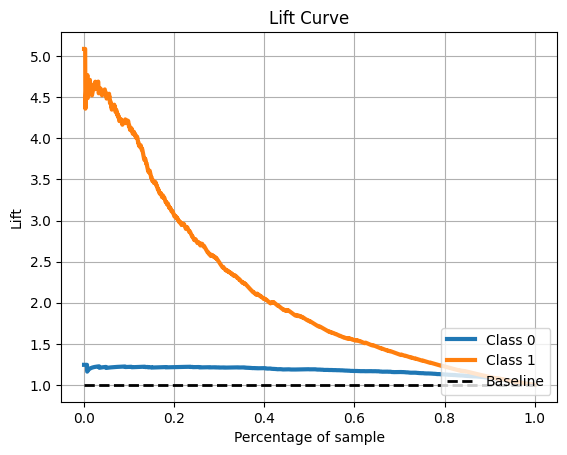

In [14]:
skplt.metrics.plot_lift_curve(y_test, y_probas)


In [31]:
models = {
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'LGBM': LGBMClassifier(class_weight='balanced')
}

In [32]:
param_grids = {
    'Random Forest': {
        'model__n_estimators': [100, 200], 
        'model__max_depth': [10, 20], 
        'model__min_samples_split': [2, 5]
    },
    'Gradient Boosting': {
        'model__learning_rate': [0.01, 0.1], 
        'model__n_estimators': [100, 200], 
        'model__max_depth': [3, 5]
    },
    'LGBM': {
        'model__learning_rate': [0.01, 0.1], 
        'model__n_estimators': [100, 200], 
        'model__max_depth': [3, 5]
    }
}

In [33]:
results = []
for name, model in models.items():
    print(f"Treinando modelo: {name}")
    
    # Cria o pipeline para o modelo atual
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  
        ('model', model)
    ])

Treinando modelo: Random Forest
Treinando modelo: Gradient Boosting
Treinando modelo: LGBM


In [34]:
param_grid = param_grids[name]

In [35]:
grid = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )

In [36]:
grid.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1644, number of negative: 6356
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

c:\Users\julio\Desktop\churn_predict_indicium\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('target_encoder',
                                                                         OneHotEncoder(),
                                                                         ['Geography']),
                                                                        ('scaler',
                                                                         StandardScaler(),
                                                                         ['CreditScore',
                                                                          'Age',
                                                                          'Tenure',
                                                                          'Balance',
                                                                          'NumOfProducts',
                                                                          'EstimatedSalary']),
                                                                        ('binary',
                                                                         'passthrough',
                                                                         ['HasCrCard',
                                                                          'IsActiveMember'])])),
                                       ('model',
                                        LGBMClassifier(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'model__learning_rate': [0.01, 0.1],
                         'model__max_depth': [3, 5],
                         'model__n_estimators': [100, 200]},
             scoring='roc_auc')

In [37]:
best_model = grid.best_estimator_
best_score = grid.best_score_
results.append({
    'model': name,
    'best_params': grid.best_params_,
    'roc_auc': best_score
})

In [38]:
for res in results:
    print(f"Modelo: {res['model']}")
    print(f"Melhores parâmetros: {res['best_params']}")


Modelo: LGBM
Melhores parâmetros: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100}


In [41]:
X = df.drop('Exited', axis=1)
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('target_encoder', OneHotEncoder(), categorical_vars),
        ('scaler', StandardScaler(), continuous_vars),
        ('binary', 'passthrough', binary_vars)  # As variáveis binárias são passadas sem transformação
    ])


X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


# Modelo XGBoost
best_params = {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
model = LGBMClassifier(
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    random_state=42
)

# Treinando o modelo
#model.fit(X_train_transformed, y_train)
print(model)
print(repr(model))

LGBMClassifier(learning_rate=0.01, max_depth=3, random_state=42)
LGBMClassifier(learning_rate=0.01, max_depth=3, random_state=42)


In [53]:
model.fit(X_train_transformed, y_train)

y_pred = model.predict(X_test_transformed)
y_pred_prob = model.predict_proba(X_test_transformed)[:, 1]

[LightGBM] [Info] Number of positive: 1644, number of negative: 6356
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 858
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.205500 -> initscore=-1.352267
[LightGBM] [Info] Start training from score -1.352267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

c:\Users\julio\Desktop\churn_predict_indicium\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\julio\Desktop\churn_predict_indicium\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\julio\Desktop\churn_predict_indicium\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [54]:
# Acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy:.4f}")

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"ROC-AUC: {roc_auc:.4f}")

# F1-Score
f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Acurácia: 0.8435
ROC-AUC: 0.8413
F1-Score: 0.3702
Confusion Matrix:
[[1595   12]
 [ 301   92]]


In [56]:
df_ks = pd.DataFrame()
df_ks['real'] = y_test
df_ks['proba'] = y_pred_prob # probabilidade de ser Churn

# Recover each class
class0 = df_ks[df_ks['real'] == 0]
class1 = df_ks[df_ks['real'] == 1]

ks = ks_2samp(class0['proba'], class1['proba'])
print(f'KS: {ks.statistic:.4f}')

KS: 0.5494


####### KS do LGBM foi menor que do RandomForest, irei seguir pelo RF

In [57]:
df = pd.read_csv("Abandono_clientes.csv", sep=',')


FileNotFoundError: [Errno 2] No such file or directory: 'Abandono_clientes.csv'

In [31]:
remover_variavel(df, 'RowNumber')
remover_variavel(df, 'CustomerId')
remover_variavel(df, 'Surname')
remover_variavel(df, 'Gender') #Gender será removido para não enviezar ou deixar o modelo discriminante


continuous_vars = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

categorical_vars = [ 'Geography']

binary_vars = ['HasCrCard', 'IsActiveMember']

In [58]:
X = df.drop('Exited',axis=1)
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
preprocessor = ColumnTransformer(
    transformers=[
        ('target_encoder', OneHotEncoder(), categorical_vars),
        ('scaler', StandardScaler(), continuous_vars),
        ('binary', 'passthrough', binary_vars)  # As variáveis binárias são passadas sem transformação
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(class_weight='balanced', random_state=42))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('target_encoder',
                                                  OneHotEncoder(),
                                                  ['Geography']),
                                                 ('scaler', StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('binary', 'passthrough',
                                                  ['HasCrCard',
                                                   'IsActiveMember'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [60]:
y_pred = pipeline.predict(X_test)
y_probas = pipeline.predict_proba(X_test)

In [61]:
df_ks = pd.DataFrame()
df_ks['real'] = y_test
df_ks['proba'] = y_probas[:, 1] # probabilidade de ser Churn

# Recover each class
class0 = df_ks[df_ks['real'] == 0]
class1 = df_ks[df_ks['real'] == 1]

ks = ks_2samp(class0['proba'], class1['proba'])
print(f'KS: {ks.statistic:.4f}')

KS: 0.5606


In [62]:
# Acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia: {accuracy:.4f}")

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_probas[:, 1])  # y_probas[:, 1] pega as probabilidades da classe 1
print(f"ROC-AUC: {roc_auc:.4f}")

# F1-Score
f1 = f1_score(y_test, y_pred)
print(f"F1-Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Acurácia: 0.8705
ROC-AUC: 0.8580
F1-Score: 0.5921
Confusion Matrix:
[[1553   54]
 [ 205  188]]


In [64]:
new_df = pd.read_csv("Datasets/Abandono_teste.csv", sep=';')

In [65]:
remover_variavel(new_df, 'RowNumber')
remover_variavel(new_df, 'CustomerId')
remover_variavel(new_df, 'Surname')
remover_variavel(new_df, 'Gender')

In [66]:
y_probas_new = pipeline.predict_proba(new_df)

threshold = 0.23
y_pred_new = (y_probas_new[:, 1] >= threshold).astype(int)


In [67]:
print("Previsões (classe):", y_pred_new)
print("Probabilidades:", y_probas_new)

Previsões (classe): [0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 1
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0
 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1 0 0 1 1
 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0
 0 0 1 1 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 1
 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 1 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0
 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 1 1 1 0 0 0 1 0 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1
 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 1 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 1
 0 0 0 1 1 0 0 0 1 1 0 0 1 0 0 0 0 1 0 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 1 1
 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0
 0 0 

In [68]:
df_new_y = new_df.copy()
df_new_y['churn_predito'] = y_pred_new
df_new_y['churn_proba'] = y_probas_new[:,1]



In [69]:
df_new_y.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,churn_predito,churn_proba
0,565,France,31,1,0.00,1,0,1,20443.08,0,0.15
1,569,France,34,4,0.00,1,0,1,4045.90,0,0.06
2,669,France,20,7,0.00,2,1,0,128838.67,0,0.00
3,694,France,39,4,173255.48,1,1,1,81293.10,0,0.11
4,504,Spain,28,10,109291.36,1,1,1,187593.15,0,0.15
